# SST: Analysis for Item Test

###Procedure

**Session 1**: 

1. Watch 4 videos of each town (2/town in a row)
2. <span style="color:red"> Item test (run 1)</span>
3. Navigation with arrows (2/town)
4. <span style="color:red">Item test (run 2)</span>

**Session 2**:

1. Watch 1 video of each town (2 for subjects 1-4)
2. <span style="color:red">Item test (run 3)</span>
3. Navigation with arrows (2/town)
4. Free navigation without arrows (2/town)
5. <span style="color:red">Item test (run 4)</span>

**Session 3**:

1. Test trials, navigate to item in each environment (2 cycles)
2. Questionnaire about strategies used, etc.
3. <span style="color:red">Item test (run 5)</span>
4. Map drawing
5. Spatial preference questionnaire

### Item test: 
Present subjects with image from town, and asked to recall the 3 items located within that town and to type the names of the items. If they didn't remember an item, they responded with a "?".


Sample image from town:

![env3](./images/env3.jpg)


## Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as op
import numpy as np

# for plotting
sns.set(style='whitegrid', context='poster')
%matplotlib inline

# R for stats
%load_ext rpy2.ipython
%R require(lme4)
%R require(lmerTest)

/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/sgagnon/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lme4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/sgagnon/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/sgagnon/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lmerTest

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/sgagnon/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘lmerTest’


  res = super(Function, self).__call__(*new_args, **new

array([1], dtype=int32)

### Define color palette

In [2]:
palette = {'face': 'orange',
           'animal': 'dodgerblue',
           'object': 'lightseagreen',
           'food':  'mediumseagreen',
           'tool': 'mediumpurple'}

## Setup paths

In [6]:
dirs = dict()
dirs['basedir'] = op.join(op.expanduser('~'), 'Experiments/SST')
dirs['datadir'] = op.join(dirs['basedir'], 'data')
dirs['analydir'] = op.join(dirs['basedir'], 'analysis')
dirs['subj_info_file'] = op.join(dirs['datadir'], 'subj_info.csv')
dirs['object_cat_file'] = op.join(dirs['datadir'], 'object_cat.csv')

In [7]:
subj_info = pd.read_csv(dirs['subj_info_file'])
subj_info = subj_info[pd.isnull(subj_info.remove)]
subj_info[['subid']] = subj_info.subid.astype(str)

subj_info

,subid,group,remove
0,1,control,NaN
1,2,control,NaN


In [8]:
#Load in file w/object sub-categories for each town, convert to dict
obj_cat = pd.read_csv(dirs['object_cat_file'])
obj_cat = obj_cat.set_index('town').to_dict()['object_cat']

## Load in data

In [10]:
dt = pd.DataFrame() 
test = True
questionnaires_post = False

for subid in subj_info.subid:
    print subid

    if test:
        # add test file
        test_file = op.join(dirs['datadir'], subid, subid + '_behav_itemTest_coded.csv')
        d2 = pd.read_csv(test_file)
        d2['subid'] = subid
        dt = dt.append(d2, ignore_index=True)
        
# Compiled group data
if questionnaires_post:
    q_file = op.join(dirs['basedir'], 'data/Quest/Questionnaires_group.csv')
    dq_post = pd.read_csv(q_file, index_col=0)
    dq_post['subid'] = dq_post.subid.astype(str)

1
2


In [11]:
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid
0,1,1,1,1.0020,58.2601,Town6,env6,1,goat clooney lettuce,46.9638,animal,0,1
1,2,1,1,1.0020,58.2601,Town6,env6,2,lettuce,6.7958,object,0,1
2,3,1,1,1.0020,58.2601,Town6,env6,3,clonney,4.4965,face,0,1
3,4,1,2,59.3028,30.2167,Town1,env1,1,cow,7.7858,animal,0,1
4,5,1,2,59.3028,30.2167,Town1,env1,2,?,20.4377,face,0,1


#### Add in sub-type for objects

In [12]:
dt['itemType_sub'] = dt.itemType
dt.ix[dt.itemType == 'object', 'itemType_sub'] = dt[dt.itemType == 'object'].town.map(obj_cat.get)
dt.head()

,index,run,trial,onset,duration,town,pic,itemNum,resp,respRT,itemType,acc,subid,itemType_sub
0,1,1,1,1.0020,58.2601,Town6,env6,1,goat clooney lettuce,46.9638,animal,0,1,animal
1,2,1,1,1.0020,58.2601,Town6,env6,2,lettuce,6.7958,object,0,1,tool
2,3,1,1,1.0020,58.2601,Town6,env6,3,clonney,4.4965,face,0,1,face
3,4,1,2,59.3028,30.2167,Town1,env1,1,cow,7.7858,animal,0,1,animal
4,5,1,2,59.3028,30.2167,Town1,env1,2,?,20.4377,face,0,1,face


In [13]:
dq_post.head()

NameError: name 'dq_post' is not defined

## Analysis

/Users/sgagnon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 1)

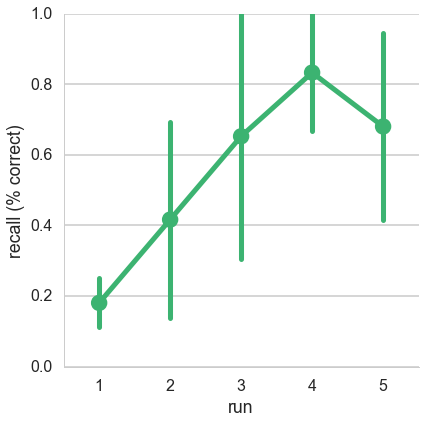

In [14]:
data = dt.groupby(['subid', 'run']).mean().reset_index()
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', 
               dodge=.2,
               units='subid', ci=68, data=data,
               color='mediumseagreen', size=6)
plt.ylim(0,1)

(-0.1, 1.1)

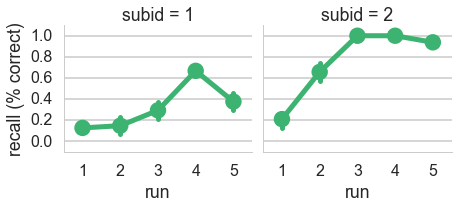

In [15]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', 
               dodge=.1, ci=68,
               col='subid', col_wrap=4, data=data,
               color='mediumseagreen', size=3)
plt.ylim(-.1,1.1)

### Accuracy across runs, by type of item

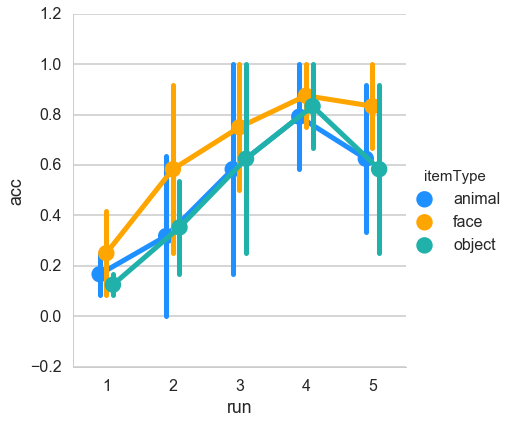

In [16]:
data = dt.groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette, size=6)

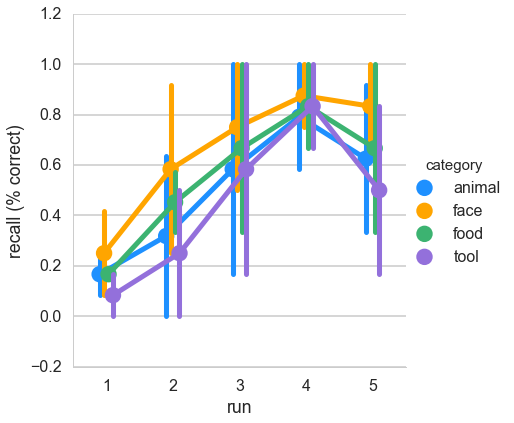

In [17]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
data['category'] = data.itemType_sub
data['recall (% correct)'] = data.acc
sns.factorplot(x='run', y='recall (% correct)', hue='category',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette, size=6)
# plt.title()

#### Mean accuracy and standard error for final training (4th) run

In [18]:
data = dt[dt.run == 4].groupby(['itemType_sub']).mean().reset_index()[['itemType_sub', 'acc']]
data['st.err'] = dt[dt.run == 4].groupby(['itemType_sub']).std().reset_index()[['acc']]/subj_info.subid.size
data

,itemType_sub,acc,st.err
0,animal,0.791667,0.207426
1,face,0.875000,0.168916
2,food,0.833333,0.194625
3,tool,0.833333,0.194625


In [19]:
data = dt[dt.run == 4].groupby('subid').mean().reset_index()
data.describe()

,index,run,trial,onset,duration,itemNum,respRT,acc
count,2.0,2,2.0,2.000000,2.000000,2,2.000000,2.000000
mean,126.5,4,6.5,113.911050,18.452762,2,6.150233,0.833333
std,0.0,0,0.0,78.175923,12.111555,0,4.037187,0.235702
min,126.5,4,6.5,58.632325,9.888600,2,3.295511,0.666667
25%,126.5,4,6.5,86.271687,14.170681,2,4.722872,0.750000
50%,126.5,4,6.5,113.911050,18.452762,2,6.150233,0.833333
75%,126.5,4,6.5,141.550412,22.734844,2,7.577594,0.916667
max,126.5,4,6.5,169.189775,27.016925,2,9.004956,1.000000


#### Broken down by subject

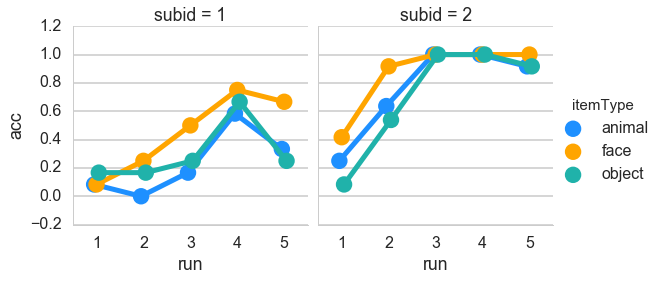

In [20]:
data = dt.groupby(['subid', 'run', 'itemType']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType',
               dodge=.1,
               col='subid', col_wrap=2, data=data,
               palette=palette)

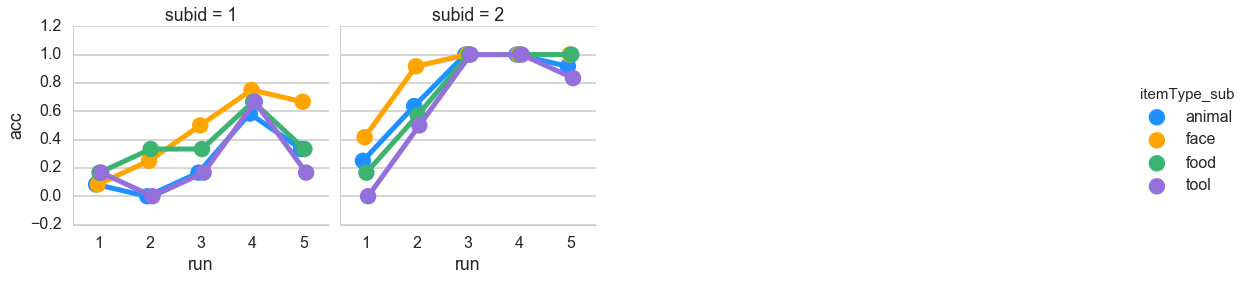

In [21]:
data = dt.groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='run', y='acc', hue='itemType_sub',
               dodge=.1,
               col='subid', col_wrap=4, data=data,
               palette=palette)

### Final training accuracy for item types

In [22]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data[data.subid.isin(['1', '2', '3', '4', '7', '8'])].describe()

,index,run,trial,onset,duration,itemNum,respRT,acc
count,2.0,2,2.0,2.000000,2.000000,2,2.000000,2.000000
mean,126.5,4,6.5,113.911050,18.452762,2,6.150233,0.833333
std,0.0,0,0.0,78.175923,12.111555,0,4.037187,0.235702
min,126.5,4,6.5,58.632325,9.888600,2,3.295511,0.666667
25%,126.5,4,6.5,86.271687,14.170681,2,4.722872,0.750000
50%,126.5,4,6.5,113.911050,18.452762,2,6.150233,0.833333
75%,126.5,4,6.5,141.550412,22.734844,2,7.577594,0.916667
max,126.5,4,6.5,169.189775,27.016925,2,9.004956,1.000000


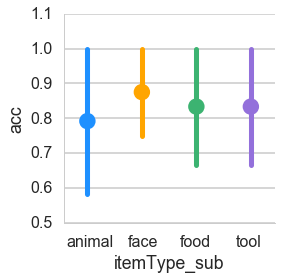

In [23]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='acc', hue='itemType_sub',
               dodge=.1,
               units='subid', ci=68, data=data, palette=palette)

### How does final training accuracy relate to spatial preference?

In [113]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')

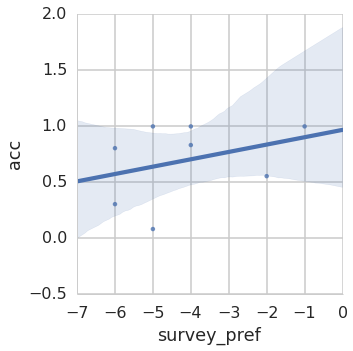

In [91]:
sns.lmplot(x='survey_pref', y='acc', 
           data=data)

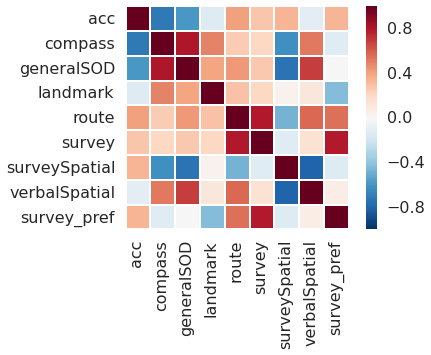

In [92]:
data = dt[dt.run == 4].groupby(['subid']).mean().reset_index()
data = data.merge(dq_post, on='subid')
dsub = data.ix[:,8:].T
sns.heatmap(np.corrcoef(dsub), 
            xticklabels=dsub.index,
            yticklabels=dsub.index,
            square=True)

#### Statistical difference between acc for different item types?

In [93]:
data = dt[dt.run == 4].groupby(['itemType_sub', 'subid', 'town']).mean().reset_index()[['subid', 'itemType_sub', 'acc', 'town']]
%R -i data

In [94]:
%%R

res1 = lmer(acc ~ itemType_sub + (1 | subid) + (1 | town), data=data)
res2 = lmer(acc ~ itemType_sub + (1 | subid), data=data)
print(anova(res2, res1, refit=FALSE))

print(summary(res1))

Data: data
Models:
object: acc ~ itemType_sub + (1 | subid)
..1: acc ~ itemType_sub + (1 | subid) + (1 | town)
       Df    AIC    BIC  logLik deviance Chisq Chi Df Pr(>Chisq)  
object  6 215.47 237.45 -101.74   203.47                          
..1     7 214.38 240.03 -100.19   200.38 3.089      1    0.07882 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by REML ['merModLmerTest']
Formula: acc ~ itemType_sub + (1 | subid) + (1 | town)
   Data: data

REML criterion at convergence: 200.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.88255 -0.41572  0.09147  0.43630  3.14387 

Random effects:
 Groups   Name        Variance Std.Dev.
 town     (Intercept) 0.004242 0.06513 
 subid    (Intercept) 0.119479 0.34566 
 Residual             0.099069 0.31475 
Number of obs: 288, groups:  town, 12; subid, 8

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)        0.64583    0.12775   7.

### Final training (run 4) accuracy across environments

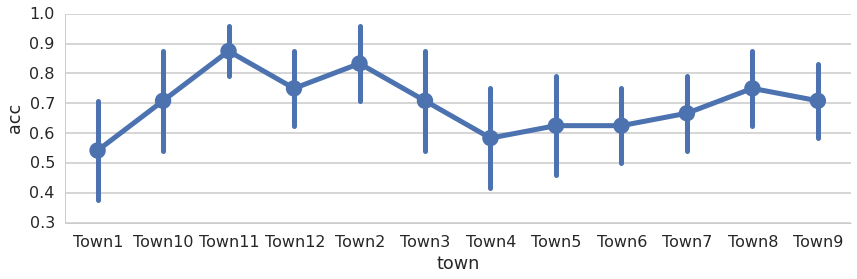

In [95]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town']).mean().reset_index()
sns.factorplot(x='town', y='acc', 
               dodge=.1, aspect=3,
               units='subid', ci=68, data=data)

#### Broken down by item type for each town

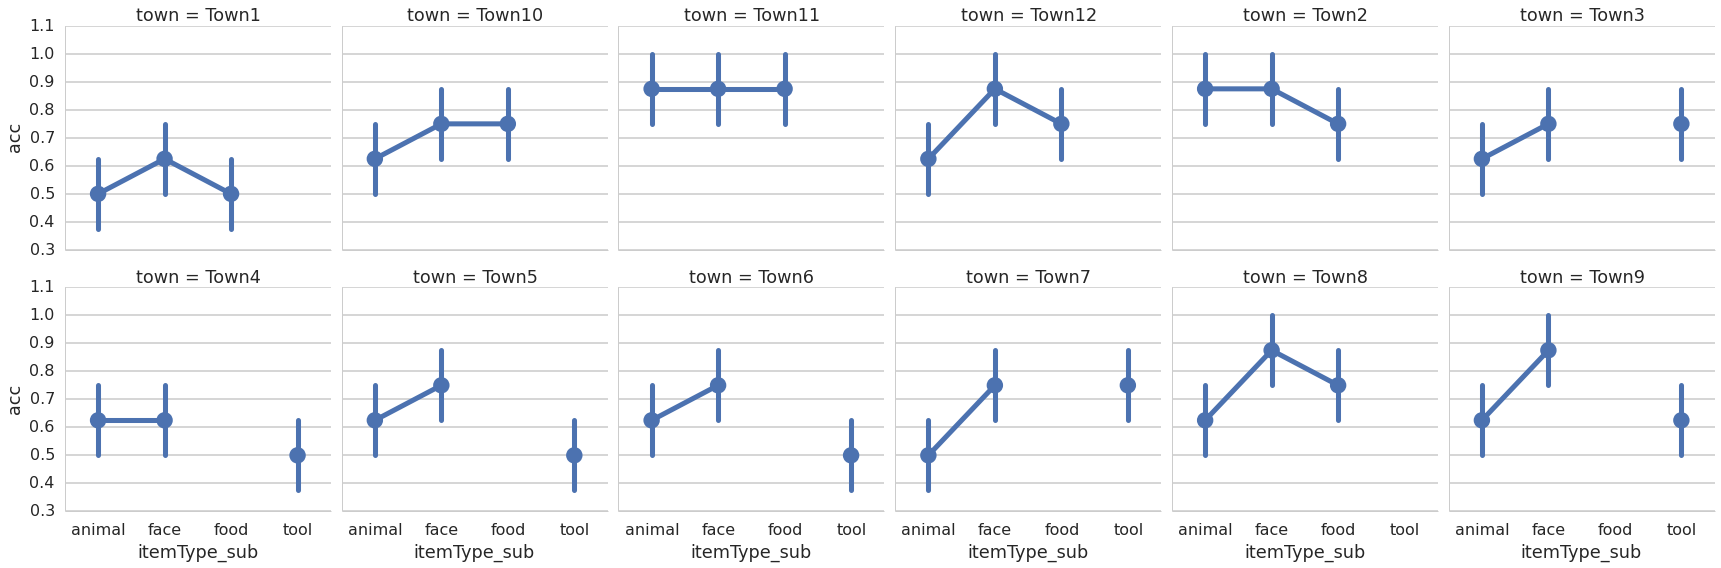

In [96]:
data = dt[dt.run == 4].groupby(['subid', 'run', 'town', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='acc', col='town', col_wrap=6,
               dodge=0, aspect=1, 
               units='subid', ci=68, data=data)

### Order of recalling items

#### Correct recall, run 4

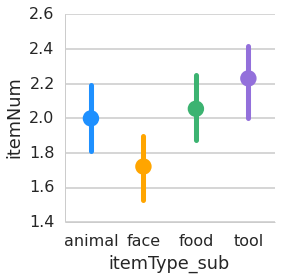

In [122]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'itemNum', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='itemNum', 
               dodge=.1,
               units='subid', ci=68, data=data, palette=palette)

In [123]:
%R -i data

In [131]:
%%R 
print(str(data))
df <- within(data, itemType_sub <- relevel(itemType_sub, ref =2))
print(summary(lmer(itemNum ~ itemType_sub + (1 | subid), data=df)))

'data.frame':	70 obs. of  10 variables:
 $ subid       : Factor w/ 8 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ itemNum     : int [1:70(1d)] 1 1 2 2 2 2 3 3 3 1 ...
 $ itemType_sub: Factor w/ 4 levels "animal","face",..: 1 2 1 2 3 4 1 3 4 1 ...
 $ index       : num [1:70(1d)] 129 124 121 130 134 ...
 $ run         : num [1:70(1d)] 4 4 4 4 4 4 4 4 4 4 ...
 $ trial       : num [1:70(1d)] 7.67 6.11 4.6 7.67 9 ...
 $ onset       : num [1:70(1d)] 68.3 50.8 36.1 68.3 80 ...
 $ duration    : num [1:70(1d)] 9.42 10.41 9.96 9.42 9.95 ...
 $ respRT      : num [1:70(1d)] 2.02 5.13 2.36 4.71 4.32 ...
 $ acc         : num [1:70(1d)] 1 1 1 1 1 1 1 1 1 1 ...
NULL
Linear mixed model fit by REML ['merModLmerTest']
Formula: itemNum ~ itemType_sub + (1 | subid)
   Data: df

REML criterion at convergence: 167

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5642 -0.9179 -0.0353  0.9776  1.6239 

Random effects:
 Groups   Name        Variance Std.Dev.
 subid    (Intercept) 0.0000 

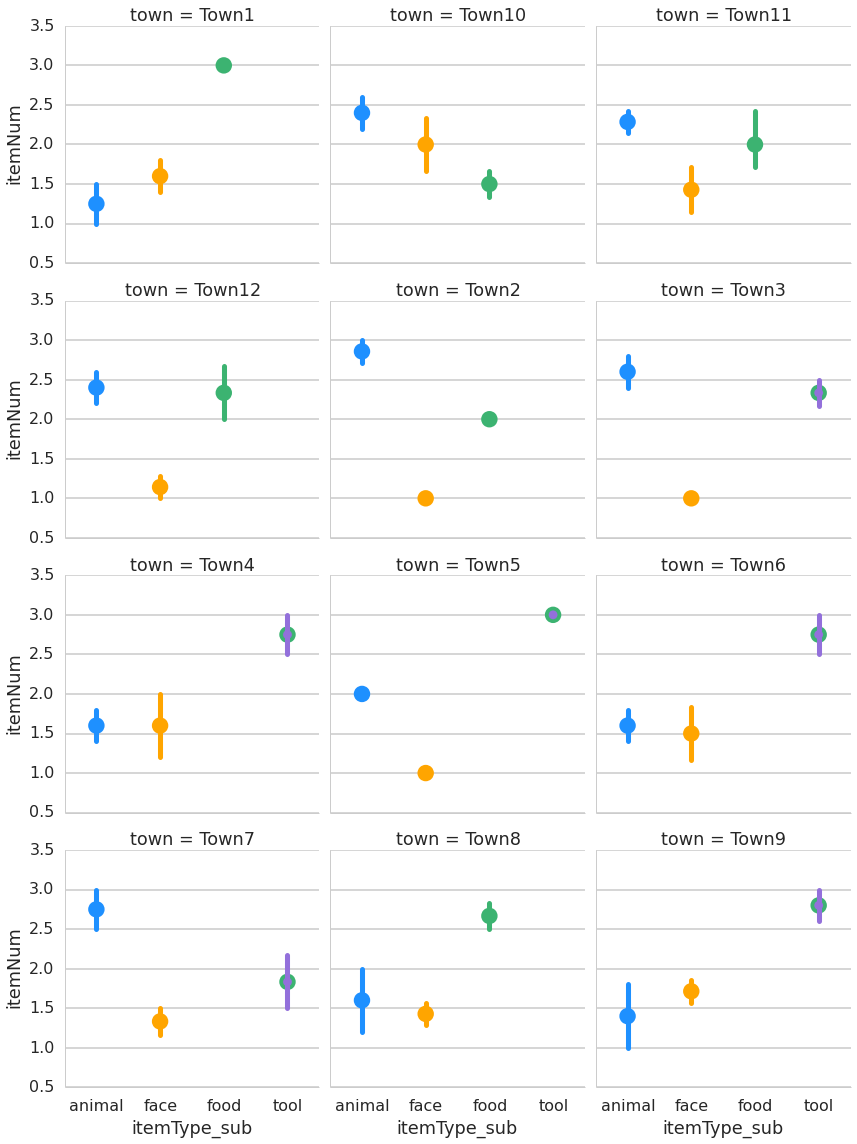

In [98]:
data = dt[(dt.acc == 1) & (dt.run==4)].groupby(['subid', 'town', 'itemNum', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='itemType_sub', y='itemNum', 
               dodge=.1, col='town', col_wrap=3,
               units='subid', ci=68, data=data, palette=palette)

#### Correct recall, across runs

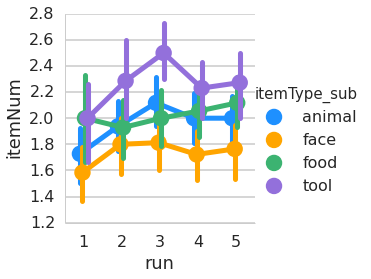

In [99]:
data = dt[(dt.acc == 1)].groupby(['subid', 'itemNum', 'itemType_sub', 'run']).mean().reset_index()
sns.factorplot(x='run', y='itemNum', hue='itemType_sub',
               dodge=.2,
               units='subid', ci=68, data=data,
               palette=palette)

## RTs for correct responses

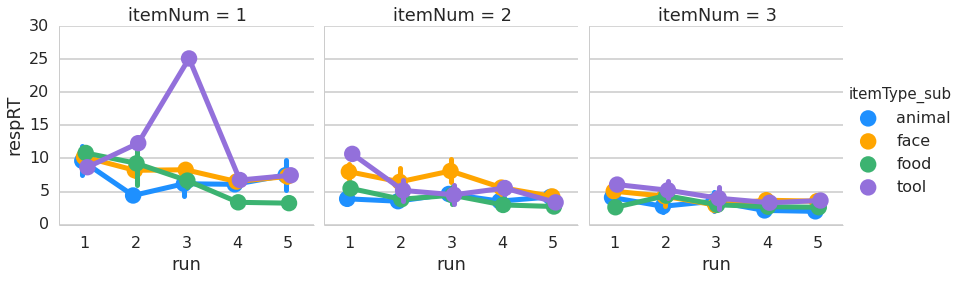

In [100]:
data = dt[dt.acc==1].groupby(['subid', 'run', 'itemType_sub', 'itemNum']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType_sub',
               col='itemNum',
               units='subid', ci=68,
               dodge=.1,
               data=data,
               palette=palette)

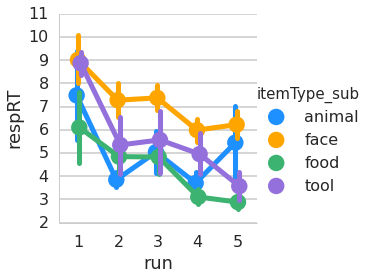

In [101]:
data = dt[dt.acc==1].groupby(['subid', 'run', 'itemType_sub']).mean().reset_index()
sns.factorplot(x='run', y='respRT', hue='itemType_sub',
               units='subid', ci=68,
               dodge=.1,
               data=data,
               palette=palette)